<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BSaoLuis%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://github.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/raw/master/DadosDiarios/saoluisdiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,27751.0,27751.000000,13871.000000,13268.000000,13794.000000,12934.000000,13612.000000,10718.000000,11316.000000,8005.000000,0.0
mean,82280.0,600.108104,5.845346,31.220327,23.874837,6.461899,2.715413,26.730203,82.508749,2.200500,NaN
std,0.0,600.010801,14.987234,1.480081,1.102441,3.190246,1.340677,0.937816,5.977846,0.924136,NaN
min,82280.0,0.000000,0.000000,24.100000,17.900000,0.000000,0.000000,22.680000,32.000000,0.000000,NaN
25%,82280.0,0.000000,0.000000,30.400000,23.100000,4.100000,1.600000,26.160000,77.750000,1.533333,NaN
50%,82280.0,1200.000000,0.000000,31.400000,23.900000,7.300000,2.600000,26.780000,82.250000,2.233333,NaN
75%,82280.0,1200.000000,3.850000,32.200000,24.700000,9.200000,3.600000,27.380000,87.000000,2.866667,NaN
max,82280.0,1200.000000,210.000000,37.200000,27.000000,11.200000,14.800000,29.900000,98.500000,5.700000,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,82280,1980-01-01,0,NaN,32.6,NaN,7.2,3.9,NaN,NaN,NaN,NaN
1,82280,1980-01-01,1200,0.0,NaN,24.9,NaN,NaN,NaN,NaN,NaN,NaN
2,82280,1980-01-02,0,NaN,32.1,NaN,9.2,4.0,NaN,NaN,NaN,NaN
3,82280,1980-01-02,1200,0.0,NaN,25.4,NaN,NaN,NaN,NaN,NaN,NaN
4,82280,1980-01-03,0,NaN,32.0,NaN,7.5,4.8,NaN,NaN,NaN,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,13268.000000,0.0,12934.000000,13612.000000,10718.000000,11316.000000,8005.000000
mean,NaN,31.220327,NaN,6.461899,2.715413,26.730203,82.508749,2.200500
std,NaN,1.480081,NaN,3.190246,1.340677,0.937816,5.977846,0.924136
min,NaN,24.100000,NaN,0.000000,0.000000,22.680000,32.000000,0.000000
25%,NaN,30.400000,NaN,4.100000,1.600000,26.160000,77.750000,1.533333
50%,NaN,31.400000,NaN,7.300000,2.600000,26.780000,82.250000,2.233333
75%,NaN,32.200000,NaN,9.200000,3.600000,27.380000,87.000000,2.866667
max,NaN,37.200000,NaN,11.200000,14.800000,29.900000,98.500000,5.700000


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,13871.000000,0.0,13794.000000,0.0,0.0,0.0,0.0,0.0
mean,5.845346,NaN,23.874837,NaN,NaN,NaN,NaN,NaN
std,14.987234,NaN,1.102441,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,17.900000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,23.100000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,23.900000,NaN,NaN,NaN,NaN,NaN
75%,3.850000,NaN,24.700000,NaN,NaN,NaN,NaN,NaN
max,210.000000,NaN,27.000000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,32.6,7.2,3.9,NaN,NaN,NaN
1980-01-02,32.1,9.2,4.0,NaN,NaN,NaN
1980-01-03,32.0,7.5,4.8,NaN,NaN,NaN
1980-01-04,32.1,9.2,4.0,NaN,NaN,NaN
1980-01-05,33.0,8.9,3.5,NaN,NaN,NaN


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1980-01-01,0.0,24.9
1980-01-02,0.0,25.4
1980-01-03,0.0,24.6
1980-01-04,0.0,25.4
1980-01-05,2.5,23.7


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,32.6,7.2,3.9,NaN,NaN,NaN,0.0,24.9
1980-01-02,32.1,9.2,4.0,NaN,NaN,NaN,0.0,25.4
1980-01-03,32.0,7.5,4.8,NaN,NaN,NaN,0.0,24.6
1980-01-04,32.1,9.2,4.0,NaN,NaN,NaN,0.0,25.4
1980-01-05,33.0,8.9,3.5,NaN,NaN,NaN,2.5,23.7


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,13268.000000,12934.000000,13612.000000,10718.000000,11316.000000,8005.000000,13871.000000,13794.000000
mean,31.220327,6.461899,2.715413,26.730203,82.508749,2.200500,5.845346,23.874837
std,1.480081,3.190246,1.340677,0.937816,5.977846,0.924136,14.987234,1.102441
min,24.100000,0.000000,0.000000,22.680000,32.000000,0.000000,0.000000,17.900000
25%,30.400000,4.100000,1.600000,26.160000,77.750000,1.533333,0.000000,23.100000
50%,31.400000,7.300000,2.600000,26.780000,82.250000,2.233333,0.000000,23.900000
75%,32.200000,9.200000,3.600000,27.380000,87.000000,2.866667,3.850000,24.700000
max,37.200000,11.200000,14.800000,29.900000,98.500000,5.700000,210.000000,27.000000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,32.6,7.2,3.9,NaN,NaN,NaN,0.0,24.9
1980-01-02,32.1,9.2,4.0,NaN,NaN,NaN,0.0,25.4
1980-01-03,32.0,7.5,4.8,NaN,NaN,NaN,0.0,24.6
1980-01-04,32.1,9.2,4.0,NaN,NaN,NaN,0.0,25.4
1980-01-05,33.0,8.9,3.5,NaN,NaN,NaN,2.5,23.7


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1980-01-01,7.2,3.9,NaN,NaN,NaN,0.0,24.9
1980-01-02,9.2,4.0,NaN,NaN,NaN,0.0,25.4
1980-01-03,7.5,4.8,NaN,NaN,NaN,0.0,24.6
1980-01-04,9.2,4.0,NaN,NaN,NaN,0.0,25.4
1980-01-05,8.9,3.5,NaN,NaN,NaN,2.5,23.7


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1980-01-01    32.6
1980-01-02    32.1
1980-01-03    32.0
1980-01-04    32.1
1980-01-05    33.0
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,12357.000000,13035.000000,10718.000000,10750.000000,7435.000000,13261.000000,13220.000000
mean,0.147697,-0.632955,0.121940,0.521817,-0.228024,-0.943556,0.305922
std,0.570358,0.181964,0.259783,0.180212,0.328164,0.143416,0.241603
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.267857,-0.783784,-0.036011,0.375940,-0.473684,-1.000000,0.120879
50%,0.303571,-0.648649,0.135734,0.511278,-0.216374,-1.000000,0.318681
75%,0.625000,-0.513514,0.301939,0.654135,0.005848,-0.961905,0.494505
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(13268, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 719.2956 - mean_absolute_error: 26.6644
Epoch 2/200
 - 1s - loss: 393.0891 - mean_absolute_error: 19.6893
Epoch 3/200
 - 1s - loss: 199.4740 - mean_absolute_error: 13.9578
Epoch 4/200
 - 1s - loss: 86.1063 - mean_absolute_error: 9.0671
Epoch 5/200
 - 1s - loss: 29.2238 - mean_absolute_error: 5.1194
Epoch 6/200
 - 1s - loss: 7.7738 - mean_absolute_error: 2.4603
Epoch 7/200
 - 1s - loss: 2.7900 - mean_absolute_error: 1.3494
Epoch 8/200
 - 1s - loss: 2.2585 - mean_absolute_error: 1.1540
Epoch 9/200
 - 1s - loss: 2.2405 - mean_absolute_error: 1.1373
Epoch 10/200
 - 1s - loss: 2.2407 - mean_absolute_error: 1.1377
Epoch 11/200
 - 1s - loss: 

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.487759, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.487759 (0.025579) {'batch_size': 10, 'camadas': 2, 'units': 7}


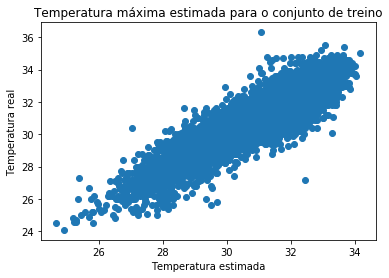

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.         0.88587534]
 [0.88587534 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

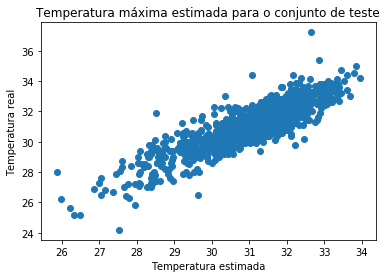

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.87253776]
 [0.87253776 1.        ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.5329889002830891


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

0.49365678399653923


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1980-01-01,32.6,7.2,3.9,NaN,NaN,NaN,0.0
1980-01-02,32.1,9.2,4.0,NaN,NaN,NaN,0.0
1980-01-03,32.0,7.5,4.8,NaN,NaN,NaN,0.0
1980-01-04,32.1,9.2,4.0,NaN,NaN,NaN,0.0
1980-01-05,33.0,8.9,3.5,NaN,NaN,NaN,2.5


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1980-01-01    24.9
1980-01-02    25.4
1980-01-03    24.6
1980-01-04    25.4
1980-01-05    23.7
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,13220.000000,12853.000000,13531.000000,10718.000000,11273.000000,7953.000000,13787.000000
mean,0.086293,0.151739,-0.633548,0.121940,0.519738,-0.229155,-0.944044
std,0.225903,0.569906,0.181408,0.259783,0.179617,0.324676,0.143049
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.038168,-0.267857,-0.783784,-0.036011,0.375940,-0.461988,-1.000000
50%,0.114504,0.303571,-0.648649,0.135734,0.511278,-0.216374,-1.000000
75%,0.236641,0.642857,-0.513514,0.301939,0.654135,0.005848,-0.961905
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(13794, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 376.6782 - mean_absolute_error: 19.2162
Epoch 2/200
 - 1s - loss: 156.7919 - mean_absolute_error: 12.3599
Epoch 3/200
 - 1s - loss: 54.4566 - mean_absolute_error: 7.1795
Epoch 4/200
 - 1s - loss: 13.4907 - mean_absolute_error: 3.3932
Epoch 5/200
 - 1s - loss: 2.6488 - mean_absolute_error: 1.3303
Epoch 6/200
 - 1s - loss: 1.2657 - mean_absolute_error: 0.9148
Epoch 7/200
 - 1s - loss: 1.2086 - mean_absolute_error: 0.8959
Epoch 8/200
 - 1s - loss: 1.2082 - mean_absolute_error: 0.8953
Epoch 9/200
 - 1s - loss: 1.2427 - mean_absolute_error: 0.8976
Epoch 10/200
 - 1s - loss: 1.2081 - mean_absolute_error: 0.8958
Epoch 11/200
 - 1s - loss: 1.2078 - mean_absolute_error: 0.8958
Epoch 12/200
 - 1s - loss: 1.2183 - mean_absolute_error: 0.8961
Epoch 13/200
 - 1s - l

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.481438, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.481438 (0.009757) {'batch_size': 10, 'camadas': 2, 'units': 7}


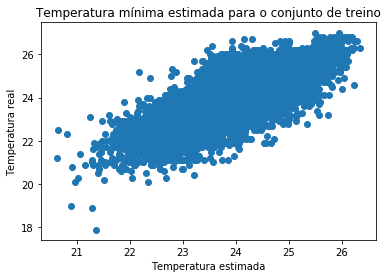

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.79519418]
 [0.79519418 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

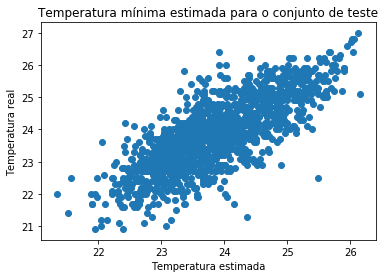

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.78110027]
 [0.78110027 1.        ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.5357928030041681


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

0.4693684077743088


In [71]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaSaoLuis.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaSaoLuis.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))